In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from bnn import MnistBNN
from adaptive_sghmc import AdaptiveSGHMC

import matplotlib.pyplot as plt

tfd = tfp.distributions

data_dir = "/scratch/gf332/Misc/datasets/"

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
mnist = tfds.load("mnist", data_dir=data_dir)

In [4]:
model_save_dir = "/scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc/prior_weight_and_bias"

In [5]:
model = MnistBNN(prior_mode="weight_and_bias")
model.build(input_shape=(1, 28, 28, 1))

optimizer = AdaptiveSGHMC(learning_rate=1e-2,
                            burnin=240,
                            data_size=60000,
                            overestimation_rate=10,
                            initialization_rounds=10,
                            momentum_decay=0.05)

ckpt = tf.train.Checkpoint(model=model,
                          optimizer=optimizer)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)#.expect_partial()
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from /scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc/prior_weight_and_bias/ckpt-833


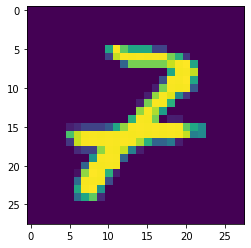

Actual:  7
Predicted:  2
Logits:  tf.Tensor(
[ -1.5332943  -12.6572485    7.304908     2.138712   -12.595425
 -13.164498    -7.544704     0.60442334   3.8411145   -7.6486797 ], shape=(10,), dtype=float32)


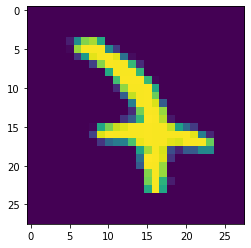

Actual:  7
Predicted:  2
Logits:  tf.Tensor(
[-14.384311    7.134467    7.3627396  -2.0081909   3.0453618 -13.987936
  -3.7084641   5.125659   -3.7861242  -3.476044 ], shape=(10,), dtype=float32)


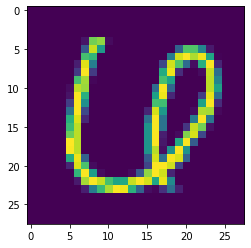

Actual:  6
Predicted:  0
Logits:  tf.Tensor(
[ 6.4499583 -3.799476  -0.6774689  4.7831554  2.557521   4.8724184
 -1.2289331 -2.2659118 -1.0130124 -1.0161657], shape=(10,), dtype=float32)


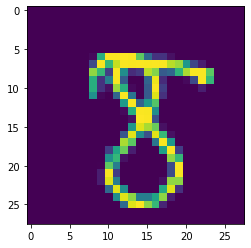

Actual:  8
Predicted:  5
Logits:  tf.Tensor(
[-16.933546   -1.8465412  -0.7741811   4.6501164 -13.1778145   6.770172
 -12.384487    2.1152005   2.074668   -6.7547846], shape=(10,), dtype=float32)


In [6]:
test_ds = mnist['test']
test_ds = test_ds.map(lambda x: (tf.cast(x["image"], tf.float32) / 255., x["label"])).shuffle(300)

for im, label in test_ds.batch(100).take(1):
    
#     plt.figure()
#     plt.imshow(im[0, ..., 0])
#     plt.show()
    
    logits = model(im)
    
    misclassified_mask = tf.argmax(logits, axis=1) != label
    
    ims = im[misclassified_mask]
    labs = label[misclassified_mask]
    logs = logits[misclassified_mask]
    
    for mis_im, lab, log in zip(ims, labs, logs):
        
        plt.figure()
        plt.imshow(mis_im[..., 0])
        plt.show()
        
        print("Actual: ", lab.numpy())
        print("Predicted: ", tf.argmax(log).numpy())
        print("Logits: ", log)
        
    
    if ims.shape[0] == 0:
        print("All correct")

In [7]:
test_accuracy = 0.
total_size = 0.

batch_size = 500

for im, label in test_ds.batch(batch_size).take(1):
    
    probs = model(im)
    
    test_accuracy += tf.reduce_sum(tf.cast(tf.argmax(probs, axis=1) == label, tf.float32))
    
    total_size += tf.cast(label.shape[0], tf.float32)
    
test_accuracy = test_accuracy / total_size

print(f"Accuracy: {test_accuracy:.3f}")

Accuracy: 0.966
